In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [148]:
import seaborn as sns
import seaborn.objects as so
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import re

from helpers.variable_interfaces import all_variables as vars
from setup.materials_setup import retrieve_cases
# from setup.data_wrangle2 import *
from analysis.helpers import map_zone_names, extract_times
from analysis.plot_helpers import set_axis_ticks
from analysis.dataframes2 import *
# from analysis.volumes import *
from helpers.ep_helpers import WallNormal
import math
from itertools import product
from analysis.cp_eq import calc_cp

sns.set_style("darkgrid")

In [149]:
cases = retrieve_cases()

In [150]:
medium_cases = [i for i in cases if "Medium" in i.case_name]
[case] = [i for i in medium_cases if "red" in i.case_name]
case

CaseData(case_name='Medium_case_red_b1', idf=<geomeppy.idf.IDF object at 0x167994d00>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_red_b1/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_red_b1'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_red_b1'))

In [151]:
wind_dirs = [i*5 for i in range(73)]

In [152]:
def compute_incident_wind_dir_angle(wall_normal, wind_dir):
    res = wind_dir - wall_normal
    inc_angle = 360 - res if res > 180 else res # hmmm... 
    return inc_angle
    

In [153]:
from typing import NamedTuple

In [154]:
class AngleSurfacePair(NamedTuple):
    wall_normal: WallNormal
    wind_dir: float

class IncidentAngleData(NamedTuple):
    wall_normal_name: str
    wind_dir: float
    incident_angle: float

class CpData(IncidentAngleData):
    cp: float

In [155]:
angles_data =[ AngleSurfacePair(*j) for j in product([i for i in WallNormal], wind_dirs)]
incident_angles = [IncidentAngleData(i.wall_normal.name, i.wind_dir, compute_incident_wind_dir_angle(i.wall_normal.value, i.wind_dir)) for i in angles_data]
cps = [calc_cp(i.incident_angle) for i in incident_angles]
df = pl.DataFrame(data= {
    "wall_normal": [i.wall_normal_name for i in incident_angles],
    "wind_dir": [i.wind_dir for i in incident_angles],
    "incident_angle": [i.incident_angle for i in incident_angles],
    "cp": [calc_cp(i.incident_angle) for i in incident_angles]
})
df

wall_normal,wind_dir,incident_angle,cp
str,i64,f64,f64
"""NORTH""",0,0.0,0.603459
"""NORTH""",5,5.0,0.594241
"""NORTH""",10,10.0,0.579945
"""NORTH""",15,15.0,0.560416
"""NORTH""",20,20.0,0.535487
…,…,…,…
"""WEST""",340,70.0,-0.05116
"""WEST""",345,75.0,-0.145147
"""WEST""",350,80.0,-0.243526


In [156]:
# df = df.with_columns(adj_wind_dir=pl.when(pl.col("wind_dir") > 180).then(180 - pl.col("wind_dir") ).otherwise(pl.col("wind_dir") ))
# df.head()

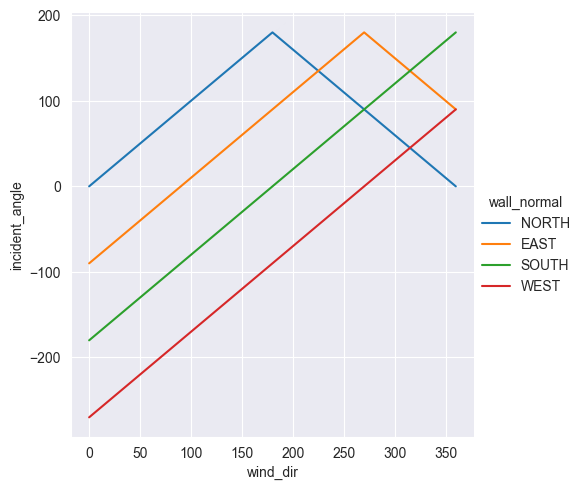

In [157]:
sns.relplot(df, x="wind_dir", y="incident_angle", hue="wall_normal", kind="line")

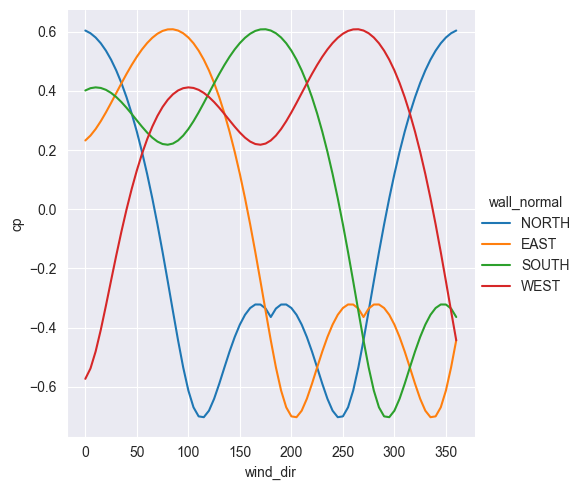

In [158]:
sns.relplot(df, x="wind_dir", y="cp", hue="wall_normal", kind="line")

In [43]:
df_pressure = get_external_node_df(case)
df_pressure

case_names,space_names,datetimes,AFN Node Wind Pressure [Pa],Site Wind Speed [m/s],Site Wind Direction [deg]
str,str,datetime[μs],f64,f64,f64
"""Medium_case_red_b1""","""ExtNode 7""",2017-07-01 00:00:00,-0.139499,1.425,305.0
"""Medium_case_red_b1""","""ExtNode 7""",2017-07-01 00:15:00,-0.111791,1.35,300.0
"""Medium_case_red_b1""","""ExtNode 7""",2017-07-01 00:30:00,-0.099015,1.275,295.0
"""Medium_case_red_b1""","""ExtNode 7""",2017-07-01 00:45:00,-0.087086,1.2,290.0
"""Medium_case_red_b1""","""ExtNode 7""",2017-07-01 01:00:00,-0.080012,1.15,290.0
…,…,…,…,…,…
"""Medium_case_red_b1""","""ExtNode 4""",2017-07-01 22:45:00,-0.294717,1.8,310.0
"""Medium_case_red_b1""","""ExtNode 4""",2017-07-01 23:00:00,-0.270799,1.725,310.0
"""Medium_case_red_b1""","""ExtNode 4""",2017-07-01 23:15:00,-0.247882,1.65,310.0


In [49]:
df_pressure = df_pressure.with_columns(wind_val= 2/(pl.col("Site Wind Speed [m/s]"))**2)
df_pressure = df_pressure.with_columns(cp_val=pl.col("AFN Node Wind Pressure [Pa]")*pl.col("wind_val"))
df_pressure

case_names,space_names,datetimes,AFN Node Wind Pressure [Pa],Site Wind Speed [m/s],Site Wind Direction [deg],wind_val,cp_val
str,str,datetime[μs],f64,f64,f64,f64,f64
"""Medium_case_red_b1""","""ExtNode 7""",2017-07-01 00:00:00,-0.139499,1.425,305.0,0.984918,-0.137395
"""Medium_case_red_b1""","""ExtNode 7""",2017-07-01 00:15:00,-0.111791,1.35,300.0,1.097394,-0.122679
"""Medium_case_red_b1""","""ExtNode 7""",2017-07-01 00:30:00,-0.099015,1.275,295.0,1.230296,-0.121817
"""Medium_case_red_b1""","""ExtNode 7""",2017-07-01 00:45:00,-0.087086,1.2,290.0,1.388889,-0.120953
"""Medium_case_red_b1""","""ExtNode 7""",2017-07-01 01:00:00,-0.080012,1.15,290.0,1.512287,-0.121001
…,…,…,…,…,…,…,…
"""Medium_case_red_b1""","""ExtNode 4""",2017-07-01 22:45:00,-0.294717,1.8,310.0,0.617284,-0.181924
"""Medium_case_red_b1""","""ExtNode 4""",2017-07-01 23:00:00,-0.270799,1.725,310.0,0.672128,-0.182011
"""Medium_case_red_b1""","""ExtNode 4""",2017-07-01 23:15:00,-0.247882,1.65,310.0,0.734619,-0.182099


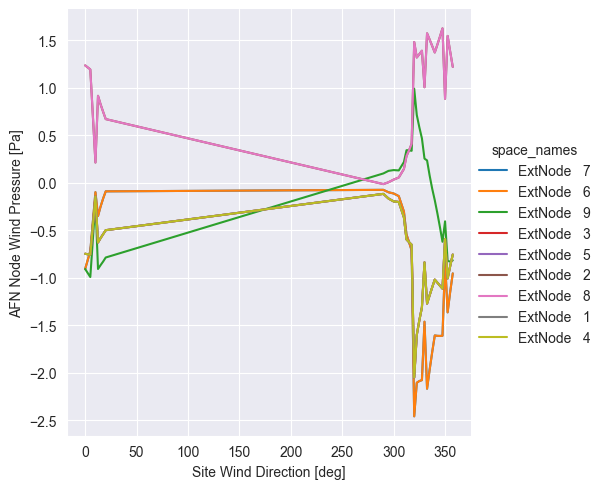

In [67]:
sns.relplot(df_pressure, x="Site Wind Direction [deg]", y="AFN Node Wind Pressure [Pa]", hue="space_names", kind="line", errorbar=None)

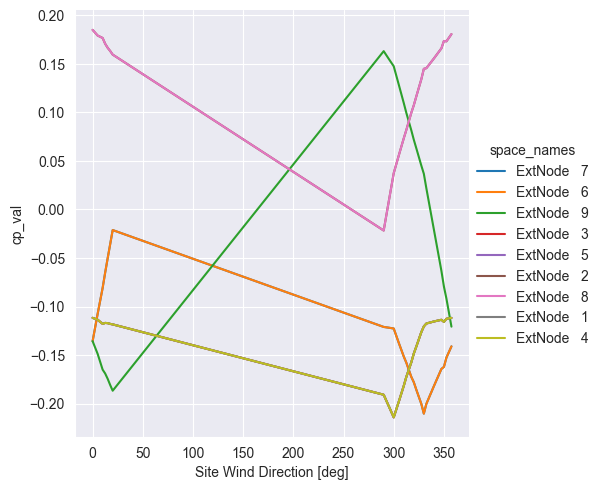

In [84]:
sns.relplot(df_pressure, x="Site Wind Direction [deg]", y="cp_val", hue="space_names", kind="line", errorbar=None)

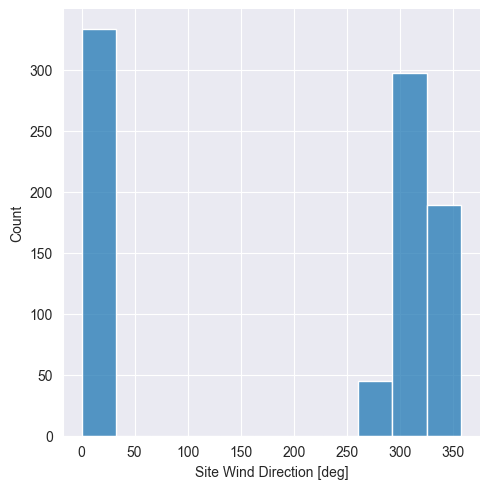

In [69]:
sns.displot(df_pressure, x="Site Wind Direction [deg]")

In [85]:
df_filtered = df.filter((pl.col("wind_dir").is_between(250, 360) ) |  (pl.col("wind_dir").is_between(0, 50) ))
df_filtered.head()

wall_normal,wind_dir,incident_angle,cp
str,i64,f64,f64
"""NORTH""",0,0.0,0.603459
"""NORTH""",5,5.0,0.594423
"""NORTH""",10,10.0,0.581261
"""NORTH""",15,15.0,0.564544
"""NORTH""",20,20.0,0.544489


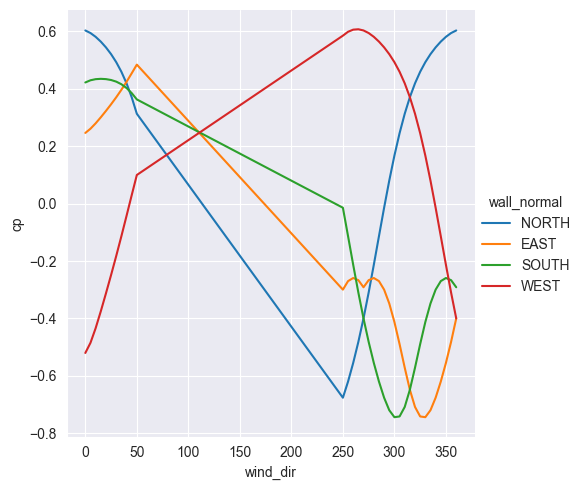

In [86]:
sns.relplot(df_filtered, x="wind_dir", y="cp", hue="wall_normal", kind="line")

In [88]:
df_an = df_filtered.pivot("wall_normal", index="wind_dir", values="cp")
df_an

wind_dir,NORTH,EAST,SOUTH,WEST
i64,f64,f64,f64,f64
0,0.603459,0.246216,0.422155,-0.520742
5,0.594423,0.260952,0.429786,-0.485375
10,0.581261,0.279685,0.433645,-0.434486
15,0.564544,0.300687,0.434802,-0.375633
20,0.544489,0.322931,0.43383,-0.313236
…,…,…,…,…
340,0.544489,-0.676707,-0.300046,-0.014522
345,0.564544,-0.620509,-0.270284,-0.113649
350,0.581261,-0.555367,-0.259448,-0.213529


In [96]:
df_exp = df_pressure.pivot("space_names", index=["datetimes", "Site Wind Direction [deg]"], values="cp_val",)
df_exp.head()

datetimes,Site Wind Direction [deg],ExtNode 7,ExtNode 6,ExtNode 9,ExtNode 3,ExtNode 5,ExtNode 2,ExtNode 8,ExtNode 1,ExtNode 4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2017-07-01 00:00:00,305.0,-0.137395,-0.137395,0.128675,-0.198173,-0.198173,0.055535,0.055535,-0.198173,-0.198173
2017-07-01 00:15:00,300.0,-0.122679,-0.122679,0.147534,-0.214201,-0.214201,0.037396,0.037396,-0.214201,-0.214201
2017-07-01 00:30:00,295.0,-0.121817,-0.121817,0.155215,-0.202522,-0.202522,0.007972,0.007972,-0.202522,-0.202522
2017-07-01 00:45:00,290.0,-0.120953,-0.120953,0.162961,-0.190755,-0.190755,-0.021687,-0.021687,-0.190755,-0.190755
2017-07-01 01:00:00,290.0,-0.121001,-0.121001,0.163026,-0.190831,-0.190831,-0.021696,-0.021696,-0.190831,-0.190831


In [98]:
df_join = pl.concat([df_exp, df_an], how="horizontal")
df_join

datetimes,Site Wind Direction [deg],ExtNode 7,ExtNode 6,ExtNode 9,ExtNode 3,ExtNode 5,ExtNode 2,ExtNode 8,ExtNode 1,ExtNode 4,wind_dir,NORTH,EAST,SOUTH,WEST
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64
2017-07-01 00:00:00,305.0,-0.137395,-0.137395,0.128675,-0.198173,-0.198173,0.055535,0.055535,-0.198173,-0.198173,0,0.603459,0.246216,0.422155,-0.520742
2017-07-01 00:15:00,300.0,-0.122679,-0.122679,0.147534,-0.214201,-0.214201,0.037396,0.037396,-0.214201,-0.214201,5,0.594423,0.260952,0.429786,-0.485375
2017-07-01 00:30:00,295.0,-0.121817,-0.121817,0.155215,-0.202522,-0.202522,0.007972,0.007972,-0.202522,-0.202522,10,0.581261,0.279685,0.433645,-0.434486
2017-07-01 00:45:00,290.0,-0.120953,-0.120953,0.162961,-0.190755,-0.190755,-0.021687,-0.021687,-0.190755,-0.190755,15,0.564544,0.300687,0.434802,-0.375633
2017-07-01 01:00:00,290.0,-0.121001,-0.121001,0.163026,-0.190831,-0.190831,-0.021696,-0.021696,-0.190831,-0.190831,20,0.544489,0.322931,0.43383,-0.313236
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2017-07-01 22:45:00,310.0,-0.151711,-0.151711,0.109754,-0.181924,-0.181924,0.073395,0.073395,-0.181924,-0.181924,null,null,null,null,null
2017-07-01 23:00:00,310.0,-0.151783,-0.151783,0.109807,-0.182011,-0.182011,0.07343,0.07343,-0.182011,-0.182011,null,null,null,null,null
2017-07-01 23:15:00,310.0,-0.151856,-0.151856,0.10986,-0.182099,-0.182099,0.073465,0.073465,-0.182099,-0.182099,null,null,null,null,null


In [ ]:
pdf_join = df_join.to_pandas()
ext_cols = sorted(df_join.select(cs.contains("Ext")).columns)
dir_cols = [i.name for i in WallNormal]




['ExtNode   1',
 'ExtNode   2',
 'ExtNode   3',
 'ExtNode   4',
 'ExtNode   5',
 'ExtNode   6',
 'ExtNode   7',
 'ExtNode   8',
 'ExtNode   9']

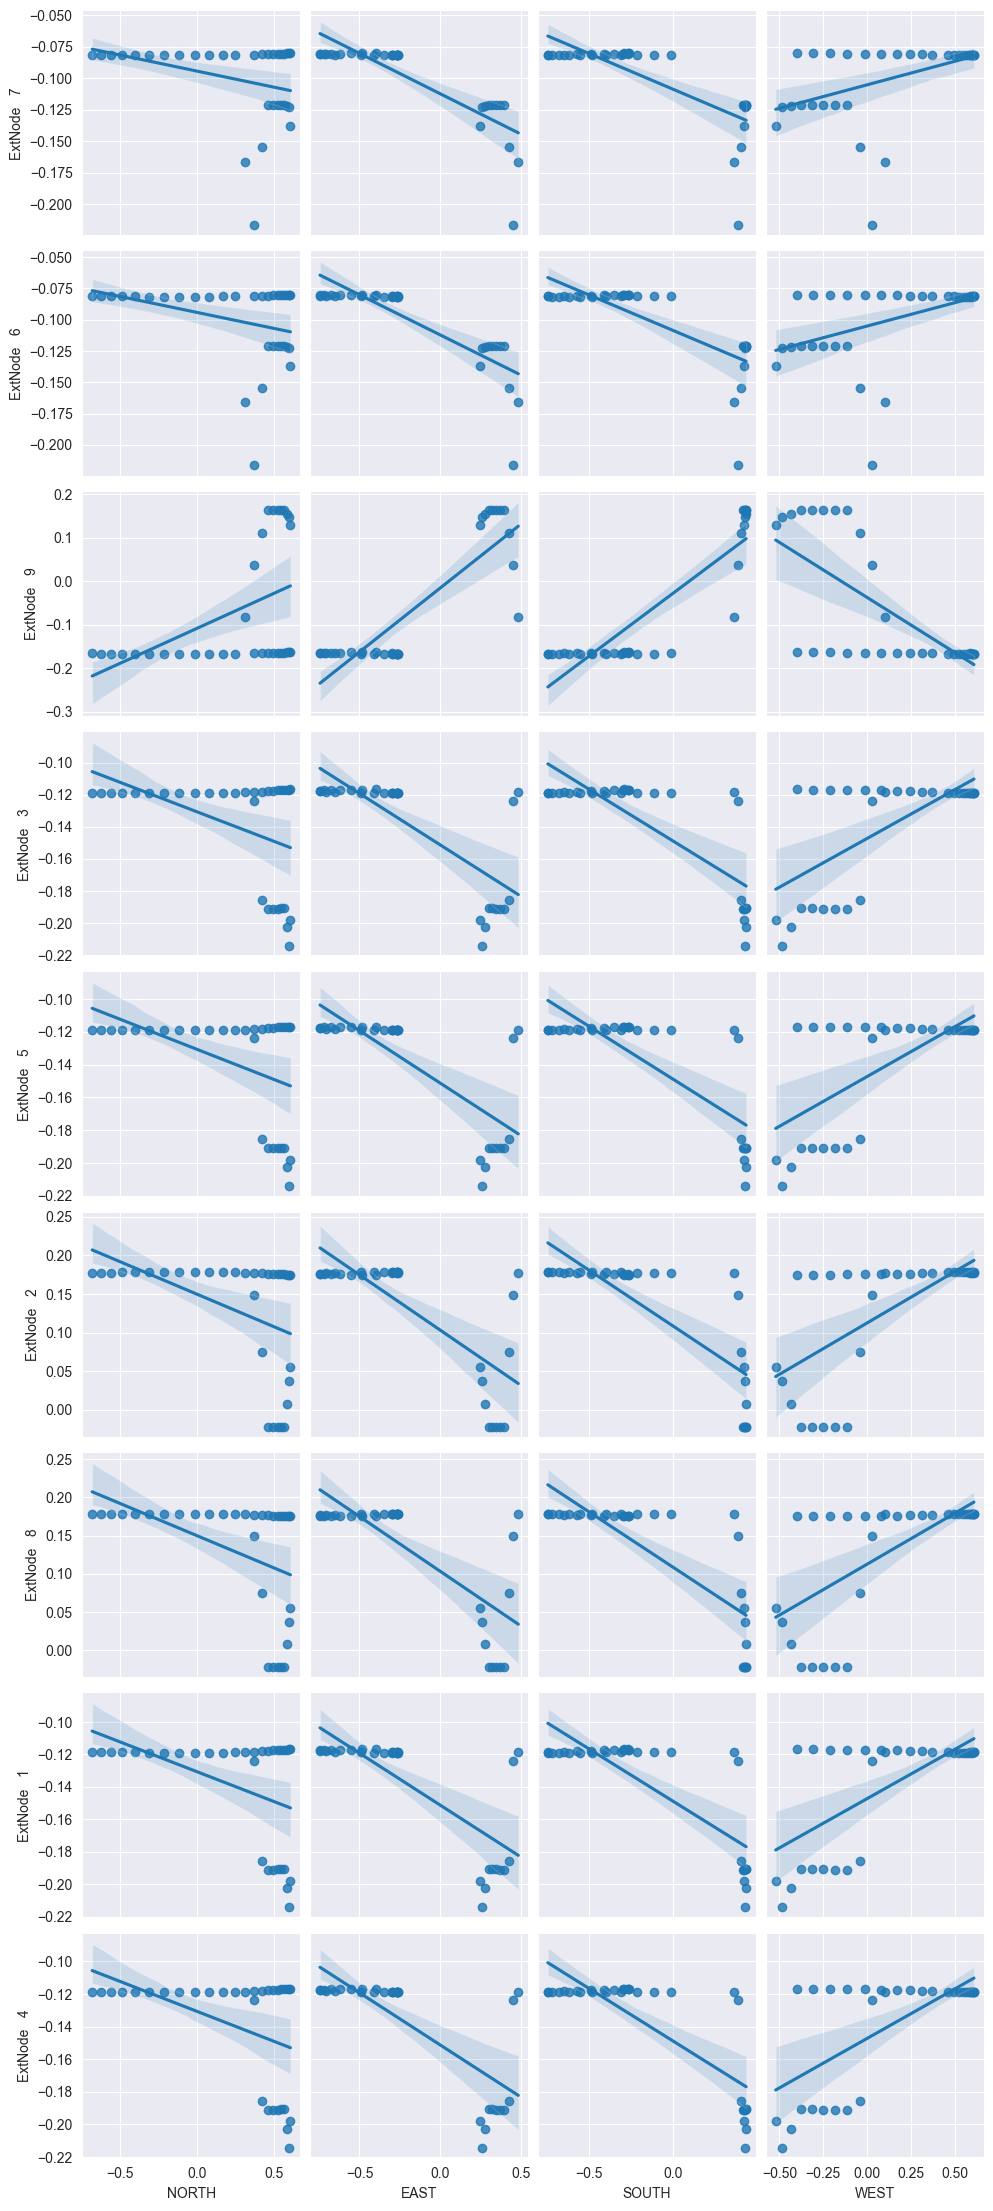

In [102]:
sns.pairplot(df_join.to_pandas(), x_vars=[i.name for i in WallNormal], y_vars=df_join.select(cs.contains("Ext")).columns, kind="reg")

In [ ]:
df_join.corr()

In [100]:
df_join.select(cs.contains("Ext")).columns

['ExtNode   7',
 'ExtNode   6',
 'ExtNode   9',
 'ExtNode   3',
 'ExtNode   5',
 'ExtNode   2',
 'ExtNode   8',
 'ExtNode   1',
 'ExtNode   4']